#### 📦 Repo Link: https://github.com/floraham/thomas_fire_analysis
> This repository contains a Jupyter Notebook (.ipynb) using Python to visualize the Thomas Fire’s Burn scar and AQI impacts in Santa Barbara, CA. We use three datasets to conduct this analysis (two for the burn scar visualization, one for AQI).


![Thomas Fire Burn Scar, November 2020, Picture taken by Author](thomas_fire_burn_scarMedium.png)

## About This Project
The Thomas Fire of December 2017, recognized as California’s largest recorded wildfire up to that point, encompassed approximately 281,893 acres in Ventura County. It prompted the evacuation of more than 104,607 residents and tragically resulted in two fatalities. This analysis examines the fire’s environmental impacts, using satellite data and fire perimeter shapefiles to create a false color image of the fire scar and assess its influence on air quality in Santa Barbara. The utilization of vector and raster data, along with basic time series analysis, aims to provide a data-driven understanding of the environmental consequences stemming from the Thomas Fire.

#### Purpose: 
This exercise aims to: 
1) create a false color image showing the fire scar of the Thomas fire in 2017 
2) visualize the Thomas fire's impact on air quality in Santa Barbara 

#### Highlights of analysis: 
- Fetch vector data from an online repository
- Visualize raster data using false color imagery 
- Time series analysis
    
#### Dataset descriptions:

##### Landsat Burn Scar Data 
- A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. 

##### California Fire Perimeters
- A shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

##### AQI Data

- We use [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. 


#### References to datasets.
- Landsat Data: The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). 

- CA Shapefile: The complete file can be accessed in the CA state geoportal (see previous link). A local copy is stored in a hidden folder in this repo. (Accessed November, 2023)

- AQI Data: https://aqs.epa.gov/aqsweb/airdata (Accessed October, 2023). 

>  Accessing AQI data: 
> 1. Go to [EPA's website on Air Quality Data Collected at Outdoor Monitors Across the US](https://www.epa.gov/outdoor-air-quality-data). 
> 2. Under "Download Data" click on "Pre-generated Data Files"
> 3. Click on "Tables of Daily AQI"
> 4. Copy the URL to the 2017 Daily AQI **by County** zip file `daily_aqi_by_county_2017.zip`
> 5. Read in the data from the URL using the `pd.read_csv` function. We store it as `aqi_17`. 
> 6. Read in the data for the 2018 Daily AQI by County zip file. We  store it as `aqi_18`.

### Importing Libraries and Functions 

In [1]:
# importing general libraries
import os
import numpy as np 
import pandas as pd 

#importing task specific libraries 
import geopandas as gpd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches #creating legends 
import shapely
import xarray as xr 
import rioxarray as rioxr 
from shapely.geometry import Polygon
from rasterio.features import rasterize #rasterizing polygons


### Importing datasets 

In [2]:
#<-----BURN SCAR-------> 

# Open the LANDSAT NetCDF file using regular open_rasterio() method
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(), 'data_fire', 'landsat8-2018-01-26-sb-simplified.nc'))

#open california fire perimeters file 
ca_fire = gpd.read_file('~/thomas_fire_analysis/data_fire/California_Fire_Perimeters')


#<------AQI-DATA---------> 
## AQI data for 2017
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

## AQI data for 2018
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

## Part 1: Visualizing Thomas Fire Burn Scar

### Data Exploration: Understanding the dataset structures 

In [3]:
#We simply print columns to look at ca_fire. Thomas fire will likely be a name under "FIRE_NAME" column. 
#it's also got polygon geometries of the fire perimeters stored in the geometry column. 

ca_fire.columns

Index(['index', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'COMPLEX_IN', 'IRWINID',
       'FIRE_NUM', 'DECADES', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [4]:
#looking at the landsat data
print(landsat)

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...


### Updates the files and project them into the same CRS

In [5]:
# drop the dimensions 
landsat = landsat.squeeze().drop('band')

#see if crs's are the same 
print(landsat.rio.crs == ca_fire.crs) ## no!  they are not the same. We'll have to convert them to the same CRS. 

## reproject ca_fire crs to landsat crs
ca_fire = ca_fire.to_crs(landsat.rio.crs)

print('CRS match:',  ca_fire.crs == landsat.rio.crs)

False
CRS match: True


### Plotting a true color image of Landsat data using red, green, and blue.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


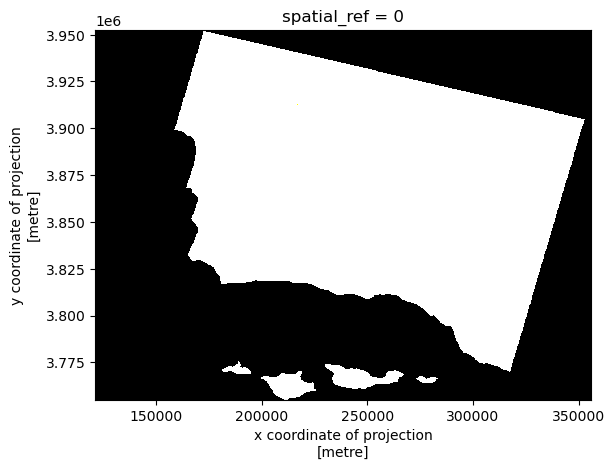

In [6]:
#select the red green and blue bands in that order
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

We can adjust the scale used for plotting the bands to get a true color image. 
> The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. 

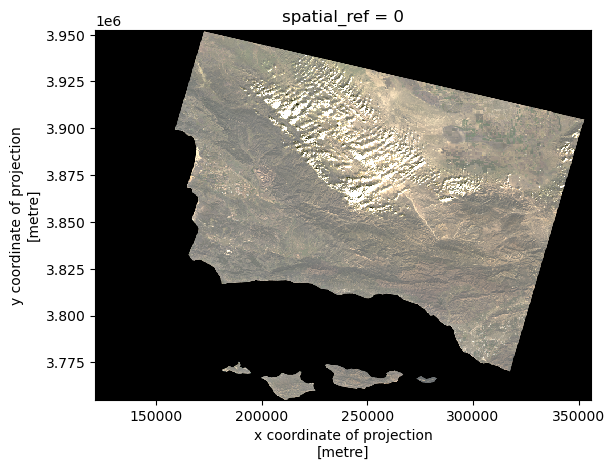

In [7]:
# parameter robust (bool, optional) – If True and vmin or vmax are absent, the colormap range is computed with 2nd and 98th percentiles instead of the extreme values.
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

### Plotting a false color image
Creating a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order).

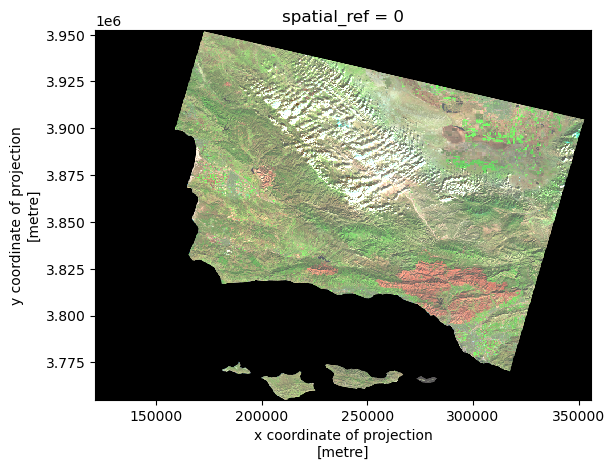

In [8]:
# creating the false color image and plotting it to see results 
fc = landsat[['swir22', 'nir08', 'red']]

#show 
fc.to_array().plot.imshow(robust = True)

### Cleaning up ca_fire dataset to select for the desired fire perimeter

In [9]:
#the column titles are capitalized and some titles have strange syntax. 

#Converting to lower and doing minor cleanup. 
ca_fire.columns = ca_fire.columns.str.lower()
ca_fire.rename(columns={'year_': 'year'}, inplace=True)

#setting the index column to "index" in case it needs to be preserved, and resetting the default index column. 
ca_fire.set_index('index').reset_index().head(4)

,index,objectid,year,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,...,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,...,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((329836.442 3778607.342, 329858.049 3..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,...,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((283091.321 3802354.285, 283072.171 3..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,...,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((317706.428 3786632.044, 317720.407 3..."
3,19839,41432,2017,CA,CCO,VNC,PACIFICA,00051791,2017-06-24,2017-06-24,...,1.158548,GPS track,None,None,None,None,2010,501.178102,6859.664843,"POLYGON ((330068.430 3778089.747, 330078.179 3..."


### Mapping the false color image with Thomas Fire perimeter

Create a map showing the shortwave infrared/nir/ ed false color image together with the Thomas fire perimeter. 
Customize it appropriately.

In [10]:
#select the row with fire_name of THOMAS, because we want the Thomas fire. 
thomas_shp = ca_fire[ca_fire['fire_name'] == 'THOMAS']

##check out what it looks like##
thomas_shp

,index,objectid,year,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,...,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
436,20274,41874,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,...,281790.875,CONT_DATE based on Inciweb,None,None,None,None,2010,540531.887458,1.681106e+09,"MULTIPOLYGON (((259241.263 3814482.913, 259193..."


### Final Output
#### Plotting fire perimeter + false color imagery

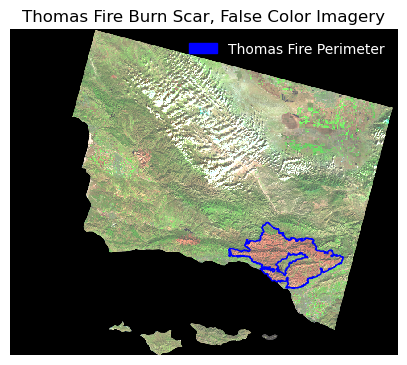

In [11]:
##--------------PLOT---------------##

fig, ax = plt.subplots(figsize = (5,5)) #setting up the figure & axis 

plt.axis("off") # turn axis off

fc.to_array().plot.imshow(robust = True, ax=ax) #plotting the false color imagery, and making sure it's on the same plot as the other plots 
thomas_shp.plot(ax = ax, color="none",  edgecolor="blue")

# use mpatches.Patch to update labels & legend
thomas_fire_border_patch = mpatches.Patch(color='blue', # change color to blue
                          label='Thomas Fire Perimeter') # update label
## add a legend 
ax.legend(handles = [thomas_fire_border_patch], 
          frameon=False, # don't inlcude legend frame 
          loc = "upper right", # adjusting location of legend 
          labelcolor = "white") # adjust text visibility

ax.set_title('Thomas Fire Burn Scar, False Color Imagery')

# displaying plot
plt.show()

## Part 2: Thomas Fire AQI Impact Analysis

### Data Exploration 

In [12]:
# Look at the structure of aqi_17. aqi_18 has the same structure. 
aqi_17

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
326796,Wyoming,Weston,56,45,2017-12-27,39,Good,Ozone,56-045-0003,1
326797,Wyoming,Weston,56,45,2017-12-28,36,Good,Ozone,56-045-0003,1
326798,Wyoming,Weston,56,45,2017-12-29,31,Good,Ozone,56-045-0003,1
326799,Wyoming,Weston,56,45,2017-12-30,31,Good,Ozone,56-045-0003,1


In [13]:
# I want see the shape of each dataframe 
print("aqi 2017 shape: ", aqi_17.shape, "\naqi 2018 shape: ", aqi_18.shape)

aqi 2017 shape:  (326801, 10) 
aqi 2018 shape:  (327537, 10)


We currently have two separate dataframes. We will need to "glue" them one on top of the other. The pandas function `pd.concat()` can achieve this. 

We pass `[aqi_17, aqi_18]` as the input of `pd.concat()` and store the output as  `aqi`.  
In the next line run `aqi`.

👀 NOTE: When we concatenate like this, without any extra parameters for `pd.concat()` the indices for the two dataframes are just "glued together", the index of the resulting dataframe is not updated to start from 0. Notice the index of `aqi` ends in 327536 while it has 654338 rows.


In [14]:
# concatenate, or "glue" aqi_17 and aqi_18 together
aqi = pd.concat([aqi_17, aqi_18])
aqi

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
327532,Wyoming,Weston,56,45,2018-12-27,36,Good,Ozone,56-045-0003,1
327533,Wyoming,Weston,56,45,2018-12-28,35,Good,Ozone,56-045-0003,1
327534,Wyoming,Weston,56,45,2018-12-29,35,Good,Ozone,56-045-0003,1
327535,Wyoming,Weston,56,45,2018-12-30,31,Good,Ozone,56-045-0003,1


### Data Cleaning 

*Format aqi dataframe nicely so we can select only data from SB County* 
- initial column names: notice caps and spaces (difficult to work with!)
- re-assign the column names - .str.lower() makes them lower case
- re-assign the column names again - .str.replace(' ','_') replaces the space for _


In [15]:
# perform changes in one line: 
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

#### In the next cells we:
- Select only data from `Santa Barbara` county and store in a new variable `aqi_sb`.
- Remove the `state_name`, `county_name`, `state_code` and `county_code` columns from `aqi_sb`. 
- Use the `dtypes` attribute to check the data types of the columns. 

In [16]:
# select rows in county_name that are "Santa Barbara" and then use drop to remove state
# name, county name, state_code, and county_code columns 

aqi_sb = aqi[aqi.county_name == "Santa Barbara"].drop(columns = ["state_name", "county_name", "state_code", "county_code"])

aqi_sb.dtypes
## I see that the date column is an object type. it should be a datetime object! 

date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object

#### In the next cells we:
1. Update the date column of `aqi_sb` to be a datetime object.
2. Update the index of `aqi_sb` to be the date column.

In [17]:
# select date column and update it to datetime, then reset the index using set_index
aqi_sb["date"] = pd.to_datetime(aqi_sb.date)
aqi_sb.set_index('date', inplace=True)

### Make an average over a rolling window.

- We can create a new variable `five_day_average` with the mean of the AQI over a 5-day rolling window. To do this use the `rolling`
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html
> Rolling() is a method for pandas.series that provides rolling window calculations the parameter '5D' indicates we want the window to be 5 days. This is a lazy method (think groupby), we need to specify what we want to calculate over each window here we add the aggregator function mean() this indicates we want the mean over each window and we get a pd.Series as ouput


In [18]:
#Now we add the mean of the AQI over a 5-day rolling window as a new column named 'five_day_average' to the `aqi_sb` dataframe. 
aqi_sb["five_day_average"] = aqi_sb.aqi.rolling('5D').mean()
aqi_sb

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,36,Good,Ozone,06-083-4003,11,37.500000
2017-01-03,71,Moderate,PM10,06-083-4003,12,48.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.000000
2017-01-05,37,Good,Ozone,06-083-4003,12,43.400000
...,...,...,...,...,...,...
2018-12-27,37,Good,Ozone,06-083-1025,11,38.600000
2018-12-28,39,Good,Ozone,06-083-1021,12,38.600000
2018-12-29,39,Good,Ozone,06-083-1021,12,38.200000


### Final Output: Graphing AQI rolling averages 

Making a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI). Updating the title and colors of the graph. 

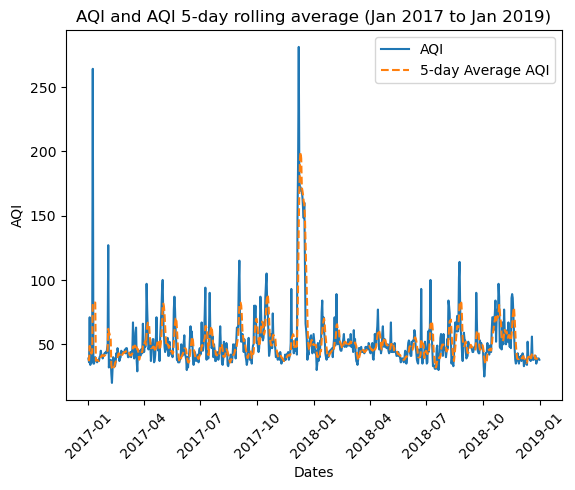

In [19]:
# use pyplot to plot the graph. set x and y variables (there are two y variables) 

x = aqi_sb.index
y1 = aqi_sb.aqi 
y2 = aqi_sb.five_day_average


plt.plot(x, y1, label = 'AQI')
plt.plot(y2, linestyle='--', label = '5-day Average AQI')

plt.xlabel('Dates')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.title('AQI and AQI 5-day rolling average (Jan 2017 to Jan 2019)')

plt.legend()

plt.show()

### We notice that: 

The AQI increases drastically during the Thomas fire (December of 2018) 
along with a drastic increase in the 5 day rolling average. The air quality was over 250 AQI. 